# Install Dependencies

In [26]:
!pip install torch==1.9.0 torchtext==0.10.0

# Import Necessary Libraries

In [27]:
import torch
import torch.nn as nn

import random
import argparse

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchtext.legacy import data
from torchtext.legacy import datasets

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import time
from datetime import datetime

# Use GPU
Set Device = CUDA if available

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyper-Parameters

In [29]:
argument_parser = argparse.ArgumentParser()
argument_parser.add_argument("--epochs", dest = "EPOCHS", type = int, default = 5)
argument_parser.add_argument("--batch_size", dest = "BATCH_SIZE", type = int, default = 16)
argument_parser.add_argument("--embed_dim", dest = "EMBED_DIM", type = int, default = 100)
argument_parser.add_argument("--optimizer", dest = "OPTIMIZER", type = str, default = 'Adam')
argument_parser.add_argument("--loss_fn", dest = "LOSS_FN", type = str, default = 'BCELoss')
argument_parser.add_argument("--learning_rate", dest = "LEARNING_RATE", type = float, default =  1e-2)
arguments, unknown = argument_parser.parse_known_args()

# Set SEED value for reproducible results
# and
# Load Dataset

In [30]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

# Create Dataset Splits and Build Vocab

In [31]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [32]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [33]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(f"Most common 20 tokens in TEXT vocabulary: {TEXT.vocab.freqs.most_common(20)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
Most common 20 tokens in TEXT vocabulary: [('the', 203592), (',', 193330), ('.', 166323), ('a', 109962), ('and', 109787), ('of', 101268), ('to', 94119), ('is', 76722), ('in', 61228), ('I', 54178), ('it', 53755), ('that', 49541), ('"', 44374), ("'s", 43358), ('this', 42543), ('-', 37707), ('/><br', 35637), ('was', 35043), ('as', 30469), ('with', 29978)]


# Dictionary for words (Vocabulary)



In [34]:
word2idx = TEXT.vocab.stoi

idx2word = { idx: word for word, idx in word2idx.items() }

unk_token = word2idx['<unk>']
padding_token = word2idx['<pad>']
print(f'UNK Token: {unk_token}')
print(f'PAD Token: {padding_token}')

UNK Token: 0
PAD Token: 1


# Add Input Dim and Output Dim to arguments

In [35]:
argument_parser.add_argument("--input_dim", dest = "INPUT_DIM", type = int, default = len(word2idx))
argument_parser.add_argument("--output_dim", dest = "OUTPUT_DIM", type = int, default = 1)
arguments, unknown = argument_parser.parse_known_args()
print(arguments)

Namespace(BATCH_SIZE=16, EMBED_DIM=100, EPOCHS=5, INPUT_DIM=25002, LEARNING_RATE=0.01, LOSS_FN='BCELoss', OPTIMIZER='Adam', OUTPUT_DIM=1)


# IMDB Dataset Class

In [36]:
class IMDBDataset(Dataset):

  def __init__(self, 
               data):
      self.data = data.examples

  def __len__(self):
      return len(self.data)

  def __getitem__(self, 
                  idx: int):
      """
      Returns
      -------
      tuple
            a tuple of encoded text and encoded label from the 
            dataset (an instance from a dataset given by idx)
      """
      # Encoding Text
      encoded_text = self.encode_text(self.data[idx].text)
      # Encoding Label
      encoded_label = self.encode_label(self.data[idx].label)
      return encoded_text, encoded_label

  def encode_text(self, 
                  text: list):
      text_vector = list()
      for word in text:
          if word in word2idx:
              text_vector.append(word2idx[word])
          else:
              text_vector.append(1)
      return text_vector

  def encode_label(self, 
                   label: int):
      label = 0 if label == 'pos' else 1
      return label

# Datset Object for DataLoader

In [37]:
train_ds = IMDBDataset(train_data)

val_ds = IMDBDataset(valid_data)

test_ds = IMDBDataset(test_data)

# Custom Collate function

In [38]:
def custom_collate_fn(batch):
    """
    Adds padding token '0' at the end of each text vector to make it
    of the same length as the maximum length input in the batch.

    Returns
    -------
    tuple
        a tuple of padded text tensors and label tensors in a batch
    """
    texts, labels = zip(*batch)
    
    texts_tensor = [torch.tensor(text, device = device) for text in texts]
    labels_tensor = torch.tensor(labels, device = device)
    
    texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = padding_token)
    
    return texts_padded, labels_tensor

# PyTorch Data Loaders

In [39]:
train_loader = DataLoader(train_ds, 
                          batch_size = arguments.BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)

val_loader = DataLoader(val_ds, 
                        batch_size = arguments.BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                         batch_size = arguments.BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = custom_collate_fn)

# Logistic Regression Model

In [40]:
class LR(nn.Module):

    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 output_dim):
        super(LR, self).__init__()
        # Initialize Embedding Layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Initialize Dense layer to predict
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, 
                x):
        # Embedding Layer
        embedded = self.embedding(x).squeeze().sum(1)
        # Fully Connected Layer
        output = self.fc(embedded)
        return output

In [41]:
model = LR(arguments.INPUT_DIM, 
           arguments.EMBED_DIM,
           arguments.OUTPUT_DIM).to(device)

print('Logistic Regression Model: ', model)

Logistic Regression Model:  LR(
  (embedding): Embedding(25002, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


# Total Trainable parameters for Logistic Regression Model

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


# Train and Validation Functions for the Model

In [43]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader, desc = 'Training...', colour = 'red')
    for x, y in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x).flatten()
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses), acc

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn):
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Evaluation...', colour = 'green')
    for x, y in pbar:

        # Calculate y_pred
        y_pred = model(x).flatten()
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
              
    return sum(losses) / len(losses), acc

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Model Training and Validation



In [45]:
# Optimizer
if arguments.OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = arguments.LEARNING_RATE)

# Loss Function
if arguments.LOSS_FN == 'BCELoss':
    loss_fn = nn.BCEWithLogitsLoss().to(device)

# Initialize Best Validation Loss
best_valid_loss = float('inf')
    
# Path to Save Best Model
PATH = f'lr-best-model.pt'

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

batch_start_time = time.time()

for epoch in range(arguments.EPOCHS):

    start_time = time.time()
    
    # Avg Train Loss, Train Accuracy
    train_loss, train_acc = train(train_loader, 
                                  model, 
                                  optimizer, 
                                  loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc.detach().cpu().numpy())

    # Avg Val Loss, Val Accuracy
    val_loss, val_acc = evaluate(val_loader, 
                                 model, 
                                 loss_fn)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc.detach().cpu().numpy())

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\n\tEpoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%\n')

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), PATH)

batch_end_time = time.time()
batch_elapsed_time = batch_end_time - batch_start_time
print(f'Training Time for Batch Size: {arguments.BATCH_SIZE} -> {batch_elapsed_time:.2f}s')

Evaluation...: 100%|██████████| 469/469 [00:02<00:00, 173.44it/s, Loss=10.8]



	Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 15.540 | Train Acc: 75.00%
	Validation Loss: 5.958 | Validation Acc: 66.67%



Evaluation...: 100%|██████████| 469/469 [00:02<00:00, 171.73it/s, Loss=6.32]



	Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 9.606 | Train Acc: 75.00%
	Validation Loss: 7.067 | Validation Acc: 91.67%



Evaluation...: 100%|██████████| 469/469 [00:02<00:00, 172.54it/s, Loss=2.76]



	Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 4.444 | Train Acc: 83.33%
	Validation Loss: 5.731 | Validation Acc: 83.33%



Evaluation...: 100%|██████████| 469/469 [00:02<00:00, 167.17it/s, Loss=7.92]



	Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 3.233 | Train Acc: 100.00%
	Validation Loss: 7.092 | Validation Acc: 75.00%



Evaluation...: 100%|██████████| 469/469 [00:02<00:00, 172.59it/s, Loss=6.9]


	Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.577 | Train Acc: 100.00%
	Validation Loss: 9.067 | Validation Acc: 83.33%

Training Time for Batch Size: 16 -> 52.21s


# Line Plot Comparison: 
1. Training vs Val Loss
2. Training vs Val Accuracy



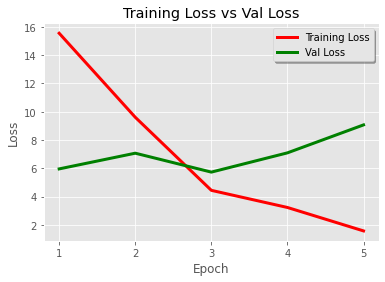

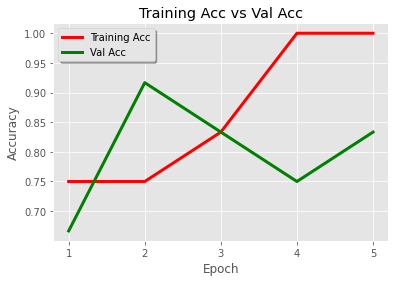

In [46]:
epochs = np.arange(arguments.EPOCHS) + 1

def plot_line(line_A_vals, 
              line_B_vals, 
              line_A_label, 
              line_B_label, 
              xlabel, 
              ylabel, 
              title):
    plt.style.use('ggplot')
    plt.plot(epochs, line_A_vals, label = line_A_label, color = "red", linewidth = '3', )
    plt.plot(epochs, line_B_vals, label = line_B_label, color = "green", linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(epochs)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()
    
# Training vs Val Loss Plot
plot_line(train_loss_list, 
          val_loss_list, 
          'Training Loss', 
          'Val Loss', 
          'Epoch', 
          'Loss', 
          'Training Loss vs Val Loss')

# Training vs Val Acc Plot
plot_line(train_acc_list, 
          val_acc_list, 
          'Training Acc', 
          'Val Acc', 
          'Epoch', 
          'Accuracy', 
          'Training Acc vs Val Acc')

## Load the saved model

In [47]:
saved_model = LR(arguments.INPUT_DIM, 
                 arguments.EMBED_DIM,
                 arguments.OUTPUT_DIM).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LR(
  (embedding): Embedding(25002, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

## Test Loss and Accuracy

In [48]:
# Avg Test Loss, Test Accuracy
test_loss, test_acc = evaluate(test_loader, 
                               saved_model, 
                               loss_fn)
print(f'\n\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluation...: 100%|██████████| 1563/1563 [00:09<00:00, 169.46it/s, Loss=0]


	Test Loss: 5.579 | Test Acc: 100.00%


# Deliverable Plots

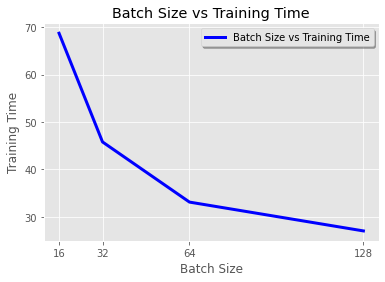

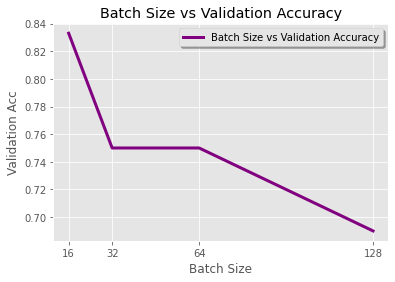

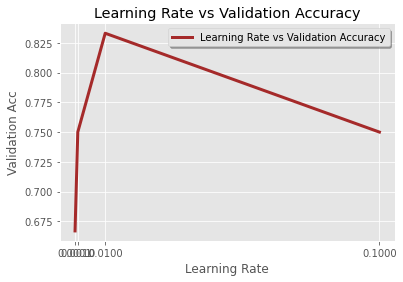

In [49]:
batch_size = [16, 32, 64, 128]
training_time = [68.71, 45.78, 33.09, 27.01]
val_set_acc = [0.833, 0.75, 0.75, 0.69]
learning_rate_vals = [0.1, 0.01, 0.001, 0.0001]
val_set_acc_lr = [0.75, 0.833, 0.75, 0.667]

def plot_comp_line(x_vals, 
              y_vals,
              line_label,
              xlabel, 
              ylabel, 
              title, 
              line_color):
    plt.style.use('ggplot')
    plt.plot(x_vals, y_vals, label = line_label, color = line_color, linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(x_vals)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()

# Batch Size vs Training Time Plot
plot_comp_line(batch_size, 
               training_time, 
               'Batch Size vs Training Time',  
               'Batch Size', 
               'Training Time',
               'Batch Size vs Training Time', 
               'blue')

# Batch Size vs Val Acc Plot
plot_comp_line(batch_size, val_set_acc, 
               'Batch Size vs Validation Accuracy', 
               'Batch Size', 
               'Validation Acc',
               'Batch Size vs Validation Accuracy', 
               'purple')

# Learning Rate vs Val Acc Plot
plot_comp_line(learning_rate_vals, val_set_acc_lr, 
               'Learning Rate vs Validation Accuracy', 
               'Learning Rate', 
               'Validation Acc',
               'Learning Rate vs Validation Accuracy', 
               'brown')

# Test of Model Correctness

In [50]:
max_n_test_instances = 5
i = 1
for x, _ in val_loader:
  score = saved_model(x).flatten()
  print(score)
  if i >= max_n_test_instances:
    break
  else:
    i += 1

tensor([ -95.7780,   51.2507,  -38.6512,   -5.9785,  -26.1995,   66.2763,
         315.7995,  -66.6742,  -54.5103,   50.3042, -324.0202,  -10.4181,
         -42.0732, -128.2762,  -53.6722,   96.7395], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([ 136.6121,   85.0782, -164.7282,  -75.1621,  181.7853,   -9.4037,
         -49.0975,  -28.7112,  210.2440,   92.8104, -154.0710,   83.9620,
         155.3648,   13.3648,    4.8885,    8.2741], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([ 323.8307, -181.7895,  -75.2958,  -44.4312,   53.9003,  102.0478,
        -107.6196,  154.1620,  -11.5863, -115.5435,  -88.1613,   -4.7317,
        -151.7569,   33.7782,  274.3875,  -76.3860], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([  51.5752,  -79.1748, -127.0843,  -69.6498,   30.7420,   39.3672,
          20.5512,  -81.6140,  -13.3014,  -44.3630,   89.2415,  154.7263,
        -133.7375,  -84.9439, -121.0648, -124.5296], device='cuda:0',
       grad_fn=<ViewBackward>)
tens